In [1]:
!which mpirun

/opt/intel/oneapi/mpi/2021.12/bin/mpirun


In [2]:
!seisflows

usage: seisflows [-h] [-w [WORKDIR]] [-p [PARAMETER_FILE]] [-v]
                 {init,configure,swap,submit,restart,clean,par,sempar,check,setup,plot2d,plotst,print,reset,debug,examples}
                 ...


                                SeisFlows v3.2.3                                


options:
  -h, --help            show this help message and exit
  -w [WORKDIR], --workdir [WORKDIR]
                        The SeisFlows working directory, default: cwd
  -p [PARAMETER_FILE], --parameter_file [PARAMETER_FILE]
                        Parameters file, default: 'parameters.yaml'
  -v, --version         Print out the current version of SeisFlows

command:
  Available SeisFlows arguments and their intended usages

    init                Runs SeisFlows first-time initiation procedures.
    configure           Fill parameter file with defaults
    swap                Swap module parameters in an existing parameter file
    submit              Submit initial workflow to system
    rest

In [3]:
pwd

'/csim1/zhangchang/testmodel'

In [4]:
import os
import glob
import shutil
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
import os
import datetime
import array
from util import *

try:
    import obspy
except:
    print("Importing obspy failed, please install obspy: pip install -U obspy")
    sys.exit(1)

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RectBivariateSpline   # replaces: interp2d
from seisflows.tools.unix import cd, cp, rm, ln, mv, mkdir
from seisflows.seisflows import SeisFlows

In [6]:
# model_list = sio.loadmat('modeltest2.mat')
model_list = sio.loadmat('layer_model.mat')
vp = model_list['vp'].astype('float32').T
vs = model_list['vs'].astype('float32').T
vp_init = model_list['vp_init'].astype('float32').T
vs_init = model_list['vs_init'].astype('float32').T
# vs_init = vs
density = 310*vp**(1/4)
dx=1
dz=1

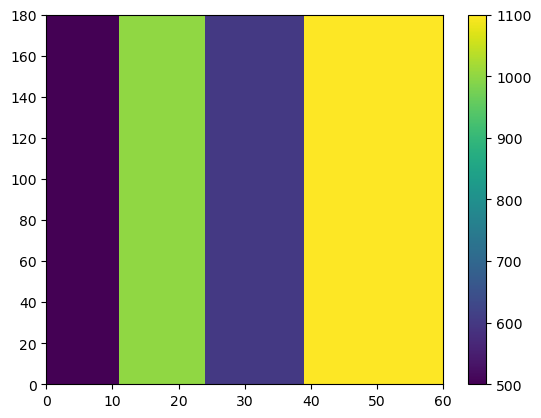

In [7]:
plt.pcolor(vs)
plt.colorbar()

    vp  min/max =   866.00 /  1905.20 (m/s)
    vs  min/max =   500.00 /  1100.00 (m/s)
    rho min/max =  1681.67 /  2048.08 (kg/m^3)

  grid: x     range min/max = 0.00 / 179.00 (m)
        depth range min/max = 0.00 / 59.00 (m)
        nx / nz             = 180 / 60
        dx / dz             = 1.00 / 1.00 (m)

        resolved maximum frequency =  100.0

  plotted as  vp.jpg



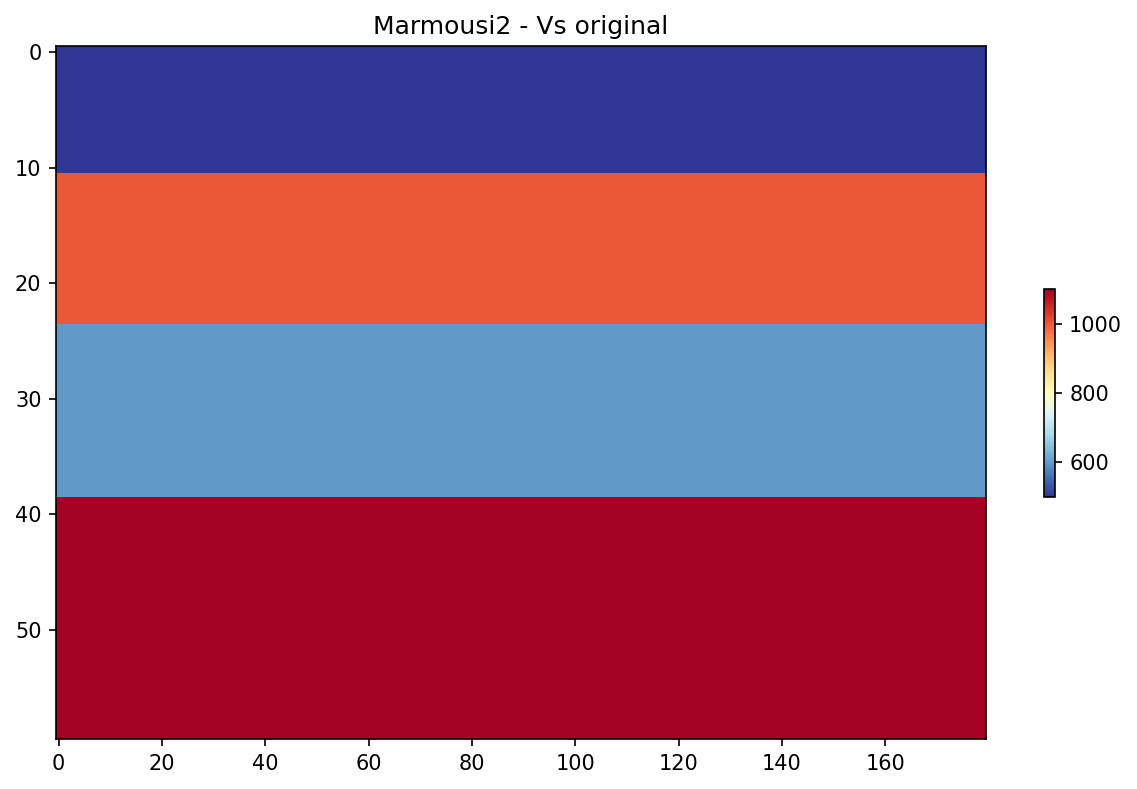

In [8]:
model_true = matmodel2specfem(vp,vs,density,dx,dz)


    vp  min/max =   866.00 /  1905.20 (m/s)
    vs  min/max =   500.00 /  1100.00 (m/s)
    rho min/max =  1681.67 /  2048.08 (kg/m^3)

  grid: x     range min/max = 0.00 / 179.00 (m)
        depth range min/max = 0.00 / 59.00 (m)
        nx / nz             = 180 / 60
        dx / dz             = 1.00 / 1.00 (m)

        resolved maximum frequency =  100.0

  plotted as  vp.jpg



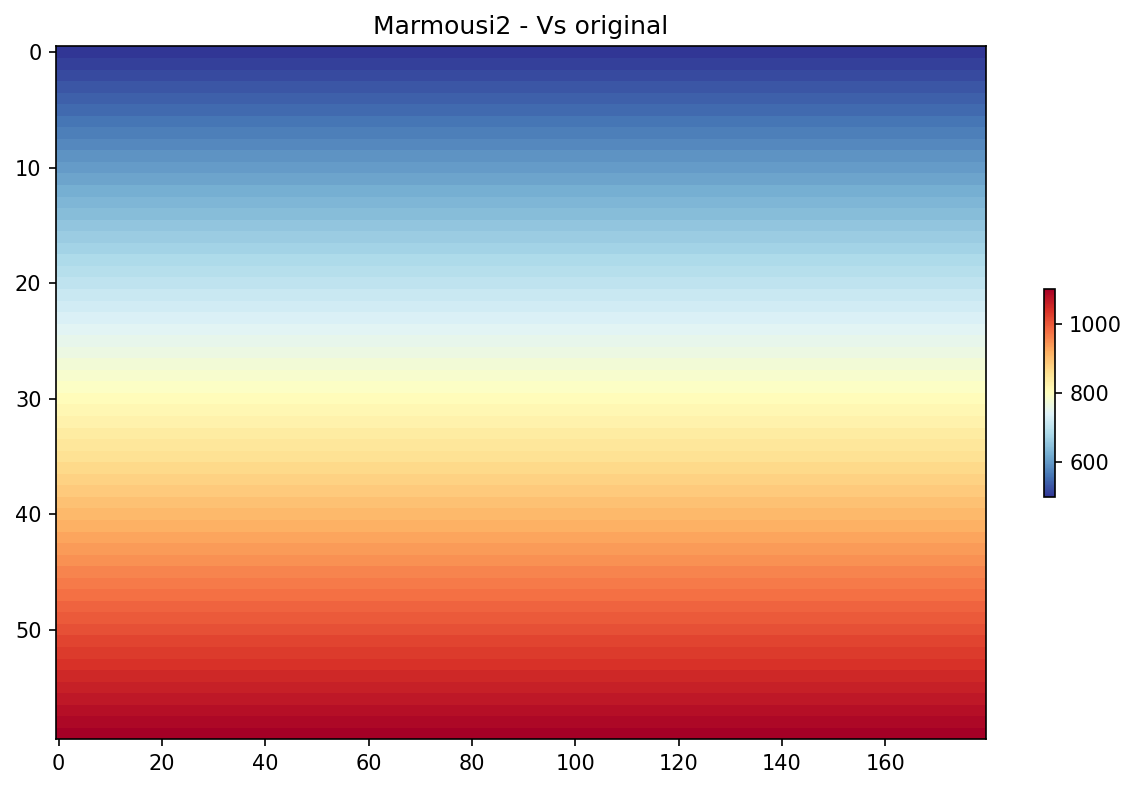

In [9]:
model_init = matmodel2specfem(vp_init,vs_init,density,dx,dz)

In [10]:
pwd

'/csim1/zhangchang/testmodel'

In [11]:
filename_true_out = "/csim1/zhangchang/testmodel/test_model_true.xyz"
filename_init_out = "/csim1/zhangchang/testmodel/test_model_init.xyz"
use_tomography_file_ascii_format=1


In [12]:
create_tomography_file(model_true,filename_true_out,use_tomography_file_ascii_format)


creating tomography file:
  dimension:
    nx / nz = 180 / 60
    dx / dz = 1 / 1 (m)
    x origin / end = 0.0 / 179.0 (m)
    z origin / end = 0.0 / 59.0 (m)

  tomographic model statistics:
    vp  min/max :   866.00 /  1905.20 (m/s)
    vs  min/max :   500.00 /  1100.00 (m/s)
    rho min/max :  1681.67 /  2048.08 (kg/m3)

  using ascii file format

tomography model written to:  /csim1/zhangchang/testmodel/test_model_true.xyz



In [13]:
create_tomography_file(model_init,filename_init_out,use_tomography_file_ascii_format)

creating tomography file:
  dimension:
    nx / nz = 180 / 60
    dx / dz = 1 / 1 (m)
    x origin / end = 0.0 / 179.0 (m)
    z origin / end = 0.0 / 59.0 (m)

  tomographic model statistics:
    vp  min/max :   866.00 /  1905.20 (m/s)
    vs  min/max :   500.00 /  1100.00 (m/s)
    rho min/max :  1681.67 /  2048.08 (kg/m3)

  using ascii file format

tomography model written to:  /csim1/zhangchang/testmodel/test_model_init.xyz



In [14]:
[nx,nz]=vp.shape
dt=dx/np.max(vp)*0.5  #公式
nt=5000

fr=30.0             #频率

ds=6
sx=np.arange(0,nx,ds)+1.0
sz=np.zeros(sx.shape)+59.0     #炮点位置
ns=len(sx)
dg=2
gx=np.arange(0,nx,dg)+1.0
gz=np.zeros(gx.shape)+59.0
ng=len(gx)

In [15]:
ns

30

In [16]:
max_dx = np.min(vs)/70
max_dx

7.142857142857143

In [17]:
dx_1=4

In [18]:
dt=0.3*dx_1/5/np.max(vp)
# dt=8e-5
dt=1e-4
# dt

In [19]:
dt

0.0001

In [20]:
!ls

DATA		      __pycache__	 test.ipynb
interfaces-Copy1.dat  scratch		 test_model_init.xyz
layer_model.mat       sflog.txt		 testmodel.mat
logs		      sfstate.txt	 test_model_true.xyz
modeltest2.mat	      SOURCE-Copy1	 util.py
output		      specfem2d		 vp.jpg
parameters.yaml       specfem2d_workdir  waveforms
Par_file-Copy1	      specfem_trace.mat
plot_2d_image.py      test_cluster


In [21]:
# vvv USER MUST EDIT THE FOLLOWING PATHS vvv
WORKDIR = "/csim1/zhangchang/testmodel"
SPECFEM2D = "/csim1/zhangchang/specfem2d"
# where WORKDIR: points to your own working directory
# and SPECFEM2D: points to an existing specfem2D repository if available (if not set as '')
# ^^^ USER MUST EDIT THE FOLLOWING PATHS ^^^
# ======================================================================================================

# Distribute the necessary file structure of the SPECFEM2D repository that we will downloaded/reference
SPECFEM2D_ORIGINAL = os.path.join(WORKDIR, "specfem2d")
SPECFEM2D_BIN_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "bin")
SPECFEM2D_DATA_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "DATA")

# The SPECFEM2D working directory that we will create separate from the downloaded repo
SPECFEM2D_WORKDIR = os.path.join(WORKDIR, "specfem2d_workdir")
SPECFEM2D_BIN = os.path.join(SPECFEM2D_WORKDIR, "bin")
SPECFEM2D_DATA = os.path.join(SPECFEM2D_WORKDIR, "DATA")
SPECFEM2D_OUTPUT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES")

# Pre-defined locations of velocity models we will generate using the solver
SPECFEM2D_MODEL_INIT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_INIT")
SPECFEM2D_MODEL_TRUE = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_TRUE")

In [22]:
# Download SPECFEM2D from GitHub, devel branch for latest codebase OR symlink from existing repo
if not os.path.exists(WORKDIR):
    os.makedirs(WORKDIR)
os.chdir(WORKDIR)

if os.path.exists("specfem2d"):
    print("SPECFEM2D repository already found, you may skip this subsection")
    pass
elif os.path.exists(SPECFEM2D):
    print("Existing SPECMFE2D respository found, symlinking to working directory")
    os.symlink(SPECFEM2D, "./specfem2d")
else:
    print("Cloning respository from GitHub")
    ! git clone --recursive --branch devel https://github.com/geodynamics/specfem2d.git
# Compile SPECFEM2D to generate the Makefile
os.chdir(SPECFEM2D_ORIGINAL)
if not os.path.exists("./config.log"):
    os.system("./configure")
# Run make to generate SPECFEM2D binaries
if not os.path.exists("bin"):
    os.system("make all")
# Check out the binary files that have been created
os.chdir(SPECFEM2D_ORIGINAL)
# Incase we've run this docs page before, delete the working directory before remaking
if os.path.exists(SPECFEM2D_WORKDIR):
    shutil.rmtree(SPECFEM2D_WORKDIR)

os.mkdir(SPECFEM2D_WORKDIR)
os.chdir(SPECFEM2D_WORKDIR)

# Copy the binary files incase we update the source code. These can also be symlinked.
shutil.copytree(SPECFEM2D_BIN_ORIGINAL, "bin")


!pwd
!ls

SPECFEM2D repository already found, you may skip this subsection
/csim1/zhangchang/testmodel/specfem2d_workdir
bin


In [23]:
if not os.path.exists(SPECFEM2D_DATA):
    os.makedirs(SPECFEM2D_DATA)
os.chdir(SPECFEM2D_DATA)
!ls

In [24]:
for i in range(ns):
    i=i+1
    print('num source',i)
    froms = WORKDIR + '/SOURCE-Copy1'
    if i<10:
        SOURCEN = 'SOURCE_00' + str(i)
    else:
        SOURCEN = 'SOURCE_0' + str(i)
    pathSOURCEN = './' + SOURCEN
    cp(froms, pathSOURCEN)
    os.system('seisflows sempar f0 ' + str(fr) + ' -P ' + SOURCEN)
    os.system('seisflows sempar xs ' + str(sx[i-1]) + ' -P ' + SOURCEN)
    os.system('seisflows sempar zs ' + str(sz[i-1]) + ' -P ' + SOURCEN)
!ls

num source 1
f0: 30.0 -> 30.0
xs: 0. -> 1.0
zs: 0. -> 59.0
num source 2
f0: 30.0 -> 30.0
xs: 0. -> 7.0
zs: 0. -> 59.0
num source 3
f0: 30.0 -> 30.0
xs: 0. -> 13.0
zs: 0. -> 59.0
num source 4
f0: 30.0 -> 30.0
xs: 0. -> 19.0
zs: 0. -> 59.0
num source 5
f0: 30.0 -> 30.0
xs: 0. -> 25.0
zs: 0. -> 59.0
num source 6
f0: 30.0 -> 30.0
xs: 0. -> 31.0
zs: 0. -> 59.0
num source 7
f0: 30.0 -> 30.0
xs: 0. -> 37.0
zs: 0. -> 59.0
num source 8
f0: 30.0 -> 30.0
xs: 0. -> 43.0
zs: 0. -> 59.0
num source 9
f0: 30.0 -> 30.0
xs: 0. -> 49.0
zs: 0. -> 59.0
num source 10
f0: 30.0 -> 30.0
xs: 0. -> 55.0
zs: 0. -> 59.0
num source 11
f0: 30.0 -> 30.0
xs: 0. -> 61.0
zs: 0. -> 59.0
num source 12
f0: 30.0 -> 30.0
xs: 0. -> 67.0
zs: 0. -> 59.0
num source 13
f0: 30.0 -> 30.0
xs: 0. -> 73.0
zs: 0. -> 59.0
num source 14
f0: 30.0 -> 30.0
xs: 0. -> 79.0
zs: 0. -> 59.0
num source 15
f0: 30.0 -> 30.0
xs: 0. -> 85.0
zs: 0. -> 59.0
num source 16
f0: 30.0 -> 30.0
xs: 0. -> 91.0
zs: 0. -> 59.0
num source 17
f0: 30.0 -> 30.0
xs: 

In [25]:
froms = WORKDIR + '/Par_file-Copy1'
SOURCEN = 'Par_file'
pathSOURCEN = './' + SOURCEN
cp(froms, pathSOURCEN)
!ls

Par_file    SOURCE_006	SOURCE_012  SOURCE_018	SOURCE_024  SOURCE_030
SOURCE_001  SOURCE_007	SOURCE_013  SOURCE_019	SOURCE_025
SOURCE_002  SOURCE_008	SOURCE_014  SOURCE_020	SOURCE_026
SOURCE_003  SOURCE_009	SOURCE_015  SOURCE_021	SOURCE_027
SOURCE_004  SOURCE_010	SOURCE_016  SOURCE_022	SOURCE_028
SOURCE_005  SOURCE_011	SOURCE_017  SOURCE_023	SOURCE_029


In [26]:
froms = WORKDIR + '/interfaces-Copy1.dat'
SOURCEN = 'interfaces.dat'
pathinterface = './' + SOURCEN
cp(froms, pathinterface)
!ls

interfaces.dat	SOURCE_005  SOURCE_011	SOURCE_017  SOURCE_023	SOURCE_029
Par_file	SOURCE_006  SOURCE_012	SOURCE_018  SOURCE_024	SOURCE_030
SOURCE_001	SOURCE_007  SOURCE_013	SOURCE_019  SOURCE_025
SOURCE_002	SOURCE_008  SOURCE_014	SOURCE_020  SOURCE_026
SOURCE_003	SOURCE_009  SOURCE_015	SOURCE_021  SOURCE_027
SOURCE_004	SOURCE_010  SOURCE_016	SOURCE_022  SOURCE_028


In [27]:
os.system('seisflows sempar NSTEP ' + str(nt))
os.system('seisflows sempar DT ' + str(dt))
os.system('seisflows sempar TOMOGRAPHY_FILE ' + filename_true_out)
os.system('seisflows sempar seismotype ' + str(1))
os.system('seisflows sempar nrec ' + str(ng))
os.system('seisflows sempar xdeb ' + str(gx[0]))
os.system('seisflows sempar zdeb ' + str(gz[0]))
os.system('seisflows sempar xfin ' + str(gx[-1]))
os.system('seisflows sempar zfin ' + str(gz[-1]))
os.system('seisflows sempar interfacesfile ' + pathinterface)
os.system('seisflows sempar xmin ' + '0.d0')
os.system('seisflows sempar xmax ' + str(nx) + '.d0')
os.system('seisflows sempar nx ' + str(nx/4))
os.system('seisflows sempar NPROC ' + str(1))

NSTEP: 5000 -> 5000
DT: 0.0001 -> 0.0001
TOMOGRAPHY_FILE: /home/user/CSIM3/chq/modeltest/test_model_true.xyz ->
/csim1/zhangchang/testmodel/test_model_true.xyz
seismotype: 1 -> 1
nrec: 10 -> 90
xdeb: 1.0 -> 1.0
zdeb: 59.0 -> 59.0
xfin: 179.0 -> 179.0
zfin: 59.0 -> 59.0
interfacesfile: ./interfaces.dat -> ./interfaces.dat
xmin: 0.0 -> 0.d0
xmax: 180.0 -> 180.d0
nx: 45 -> 45.0
NPROC: 1 -> 1


0

In [28]:
# First we will set the correct SOURCE and STATION files.
# This is the same task as shown in ./run_this_example.sh
os.chdir(SPECFEM2D_DATA)

# Symlink source 001 as our main source
if os.path.exists("SOURCE"):
    os.remove("SOURCE")
os.symlink("SOURCE_001", "SOURCE")



!ls

interfaces.dat	SOURCE_004  SOURCE_010	SOURCE_016  SOURCE_022	SOURCE_028
Par_file	SOURCE_005  SOURCE_011	SOURCE_017  SOURCE_023	SOURCE_029
SOURCE		SOURCE_006  SOURCE_012	SOURCE_018  SOURCE_024	SOURCE_030
SOURCE_001	SOURCE_007  SOURCE_013	SOURCE_019  SOURCE_025
SOURCE_002	SOURCE_008  SOURCE_014	SOURCE_020  SOURCE_026
SOURCE_003	SOURCE_009  SOURCE_015	SOURCE_021  SOURCE_027


In [29]:
# os.chdir(SPECFEM2D_DATA)

# Ensure that SPECFEM2D outputs the velocity model in the expected binary format
!seisflows sempar setup_with_binary_database 1  # allow creation of .bin files
!seisflows sempar save_model binary  # output model in .bin database format
!seisflows sempar save_ascii_kernels .false.  # output kernels in .bin format, not ASCII

setup_with_binary_database: 1 -> 1
SAVE_MODEL: binary -> binary
save_ASCII_kernels: .false. -> .false.


In [30]:
# GENERATE MODEL_TRUE
os.chdir(SPECFEM2D_DATA)

# Edit the Par_file by increasing velocities by ~10%
os.system('seisflows sempar TOMOGRAPHY_FILE ' + filename_init_out)

TOMOGRAPHY_FILE: /csim1/zhangchang/testmodel/test_model_true.xyz ->
/csim1/zhangchang/testmodel/test_model_init.xyz


0

In [31]:
# SPECFEM requires that we create the OUTPUT_FILES directory before running
os.chdir(SPECFEM2D_WORKDIR)

if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)

os.mkdir(SPECFEM2D_OUTPUT)

!ls

bin  DATA  OUTPUT_FILES


In [32]:
!which mpirun

/opt/intel/oneapi/mpi/2021.12/bin/mpirun


In [33]:
# GENERATE MODEL_INIT
os.chdir(SPECFEM2D_WORKDIR)

# Run the mesher and solver to generate our initial model
!./bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!./bin/xspecfem2D > OUTPUT_FILES/solver_log.txt
# GENERATE MODEL_TRUE
# os.chdir(SPECFEM2D_DATA)

# # Edit the Par_file by increasing velocities by ~10%
# os.system('seisflows sempar TOMOGRAPHY_FILE ' + "")
# os.chdir(SPECFEM2D_WORKDIR)
# Move the model files (*.bin) into the OUTPUT_FILES directory, where SeisFlows3 expects them
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite this initial model when creating our target model in the next step
!mv OUTPUT_FILES OUTPUT_FILES_INIT

!head OUTPUT_FILES_INIT/solver_log.txt
!tail OUTPUT_FILES_INIT/solver_log.txt

 
 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************
 
 Running Git version of the code corresponding to 
 e70c9c88e5f0a1edc64870c514ef52d08e5d1ef0
 dating 2024-06-05 17:41:24 +0200
 
 There are            1  MPI processes
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 model test
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 30 - 06 - 2024                                 T i m e  : 22:46:41
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


In [34]:
# GENERATE MODEL_TRUE
os.chdir(SPECFEM2D_DATA)

# Edit the Par_file by increasing velocities by ~10%
os.system('seisflows sempar TOMOGRAPHY_FILE ' + filename_true_out)

TOMOGRAPHY_FILE: /csim1/zhangchang/testmodel/test_model_init.xyz ->
/csim1/zhangchang/testmodel/test_model_true.xyz


0

In [35]:
# SPECFEM requires that we create the OUTPUT_FILES directory before running
os.chdir(SPECFEM2D_WORKDIR)

if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)

os.mkdir(SPECFEM2D_OUTPUT)

!ls

bin  DATA  OUTPUT_FILES  OUTPUT_FILES_INIT


In [36]:
# GENERATE MODEL_TRUE
os.chdir(SPECFEM2D_WORKDIR)

# Run the mesher and solver to generate our initial model
!./bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!./bin/xspecfem2D > OUTPUT_FILES/solver_log.txt
# os.chdir(SPECFEM2D_DATA)

# # Edit the Par_file by increasing velocities by ~10%
# os.system('seisflows sempar TOMOGRAPHY_FILE ' + "")
# os.chdir(SPECFEM2D_WORKDIR)
# Move the model files (*.bin) into the OUTPUT_FILES directory, where SeisFlows3 expects them
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite this initial model when creating our target model in the next step
!mv OUTPUT_FILES OUTPUT_FILES_TRUE

!head OUTPUT_FILES_TRUE/solver_log.txt
!tail OUTPUT_FILES_TRUE/solver_log.txt

 
 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************
 
 Running Git version of the code corresponding to 
 e70c9c88e5f0a1edc64870c514ef52d08e5d1ef0
 dating 2024-06-05 17:41:24 +0200
 
 There are            1  MPI processes
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 model test
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 30 - 06 - 2024                                 T i m e  : 22:46:57
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


In [37]:
!ls

bin  DATA  OUTPUT_FILES_INIT  OUTPUT_FILES_TRUE


In [38]:
!seisflows -h

usage: seisflows [-h] [-w [WORKDIR]] [-p [PARAMETER_FILE]] [-v]
                 {init,configure,swap,submit,restart,clean,par,sempar,check,setup,plot2d,plotst,print,reset,debug,examples}
                 ...


                                SeisFlows v3.2.3                                


options:
  -h, --help            show this help message and exit
  -w [WORKDIR], --workdir [WORKDIR]
                        The SeisFlows working directory, default: cwd
  -p [PARAMETER_FILE], --parameter_file [PARAMETER_FILE]
                        Parameters file, default: 'parameters.yaml'
  -v, --version         Print out the current version of SeisFlows

command:
  Available SeisFlows arguments and their intended usages

    init                Runs SeisFlows first-time initiation procedures.
    configure           Fill parameter file with defaults
    swap                Swap module parameters in an existing parameter file
    submit              Submit initial workflow to system
    rest

In [38]:
WORKDIR

'/csim1/zhangchang/testmodel'

In [39]:
# The command 'setup' creates the 'parameters.yaml' file that controls all of SeisFlows
# the '-f' flag removes any exist 'parameters.yaml' file that might be in the directory
os.chdir(WORKDIR)
# !seisflows init 
!ls

DATA		      plot_2d_image.py	 test_cluster	      util.py
interfaces-Copy1.dat  __pycache__	 test.ipynb	      vp.jpg
modeltest2.mat	      SOURCE-Copy1	 test_model_init.xyz
parameters.yaml       specfem2d		 testmodel.mat
Par_file-Copy1	      specfem2d_workdir  test_model_true.xyz


In [40]:
!seisflows par workflow inversion
!seisflows par system cluster
# !seisflows configure

workflow: inversion -> inversion
system: cluster -> cluster


In [155]:
# EDIT THE SEISFLOWS PARAMETER FILE
!seisflows par ntask 30  # set the number of sources/events to use
!seisflows par materials elastic  # update Vp and Vs during inversion
!seisflows par end 10  # final iteration -- we will only run 1
# !seisflows par data_case synthetic  # synthetic-synthetic means we need both INIT and TRUE models
!seisflows par step_count_max 5  # limit the number of steps in the line search
!seisflows par unit_output DISP  # limit the number of steps in the line search
!seisflows par generate_data True 
!seisflows par ntask_max 30
# Use Python syntax here to access path constants
os.system(f"seisflows par path_specfem_bin {SPECFEM2D_BIN}")  # set path to SPECFEM2D binaries
os.system(f"seisflows par path_specfem_data {SPECFEM2D_DATA}")  # set path to SEPCFEM2D DATA/
os.system(f"seisflows par path_model_init {SPECFEM2D_MODEL_INIT}")  # set path to INIT model
os.system(f"seisflows par path_model_true {SPECFEM2D_MODEL_TRUE}")  # set path to TRUE model

ntask: 30 -> 30
materials: elastic -> elastic
end: 10 -> 10
step_count_max: 5 -> 5
unit_output: DISP -> DISP
generate_data: True -> True
ntask_max: 383 -> 30
path_specfem_bin: /csim1/zhangchang/testmodel/specfem2d_workdir/bin ->
/csim1/zhangchang/testmodel/specfem2d_workdir/bin
path_specfem_data: /csim1/zhangchang/testmodel/specfem2d_workdir/DATA ->
/csim1/zhangchang/testmodel/specfem2d_workdir/DATA
path_model_init: /csim1/zhangchang/testmodel/specfem2d_workdir/OUTPUT_FILES_INIT
-> /csim1/zhangchang/testmodel/specfem2d_workdir/OUTPUT_FILES_INIT
path_model_true: /csim1/zhangchang/testmodel/specfem2d_workdir/OUTPUT_FILES_TRUE
-> /csim1/zhangchang/testmodel/specfem2d_workdir/OUTPUT_FILES_TRUE


0

In [41]:
SPECFEM2D_DATA

'/csim1/zhangchang/testmodel/specfem2d_workdir/DATA'

In [42]:
os.chdir(SPECFEM2D_DATA)
!seisflows sempar model gll
!seisflows sempar velocity_model '1 1 1960.d0 1600.d0 800.0d0 0 0 9999 9999 0 0 0 0 0 0'
#           #       #model_number 1 rho Vp Vs k 0 QKappa Qmu 0 0 0 0 0 0

MODEL: default -> gll
Traceback (most recent call last):
  File "/home/zhangchang/miniconda3/envs/seisflow_devel/bin/seisflows", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 1456, in main
    sf()
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 456, in __call__
    getattr(self, self._args.command)(**vars(self._args))
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 972, in sempar
    setpar_vel_model(file=par_file, model=value.split("+"))
  File "/csim1/zhangchang/seisflow_devel/seisflows/tools/specfem.py", line 620, in setpar_vel_model
    model_idx_start = model_lines[0]
                      ~~~~~~~~~~~^^^
IndexError: list index out of range


In [43]:
WORKDIR

'/csim1/zhangchang/testmodel'

In [39]:
os.chdir(WORKDIR)
!seisflows print tasks

                          SEISFLOWS WORKFLOW TASK LIST                          
                          ////////////////////////////                          
Task list for <class 'seisflows.workflow.inversion.Inversion'>

1: generate_synthetic_data
2: evaluate_initial_misfit
3: run_adjoint_simulations
4: postprocess_event_kernels
5: evaluate_gradient_from_kernels
6: initialize_line_search
7: evaluate_line_search_misfit
8: update_line_search
9: finalize_iteration


In [40]:
pwd

'/csim1/zhangchang/testmodel'

In [41]:
!seisflows clean


                                     CLEAN                                      
                                     /////                                      
This will remove all workflow objects leaving only the parameter file. Are you
sure you want to continue? (y/[n])
^C
Traceback (most recent call last):
  File "/home/zhangchang/miniconda3/envs/seisflow_devel/bin/seisflows", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 1456, in main
    sf()
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 456, in __call__
    getattr(self, self._args.command)(**vars(self._args))
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 836, in clean
    check = input(msg.cli("This will remove all workflow objects "
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [ ]:
!seisflows submit

In [42]:
from seisflows.tools.config import import_seisflows
import os

a = import_seisflows(workdir=os.getcwd(), parameter_file="parameters.yaml")

In [42]:
import os
from seisflows.tools.model import Model
from plot_2d_image import plot_2d_image

true_model = Model(os.path.join("output", "MODEL_TRUE"))
init_model = Model(os.path.join("output", "MODEL_INIT"))
model1 = Model(os.path.join("output", "MODEL_02"))

2024-06-30 21:50:02 [WARN] | no/invalid `path` given, initializing empty Model


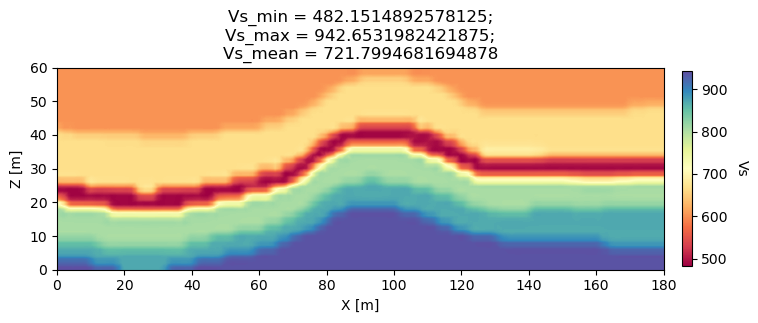

In [45]:
init_model.plot2d("vs")

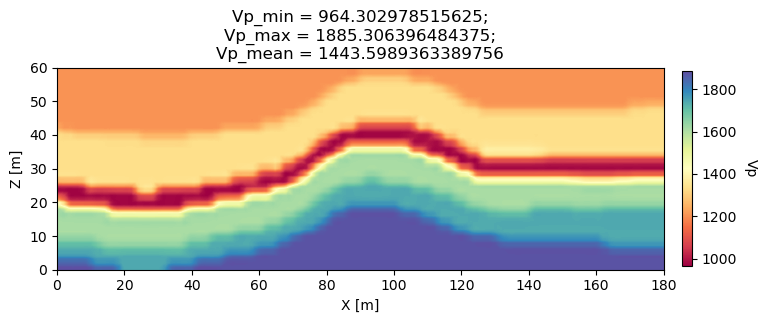

In [44]:
true_model.plot2d("vp")

In [71]:
!cp /csim1/zhangchang/testmodel/output/MODEL_TRUE/proc000000_x.bin /csim1/zhangchang/testmodel/output/GRADIENT_01/proc000000_x.bin 
!cp /csim1/zhangchang/testmodel/output/MODEL_TRUE/proc000000_z.bin /csim1/zhangchang/testmodel/output/GRADIENT_01/proc000000_z.bin 

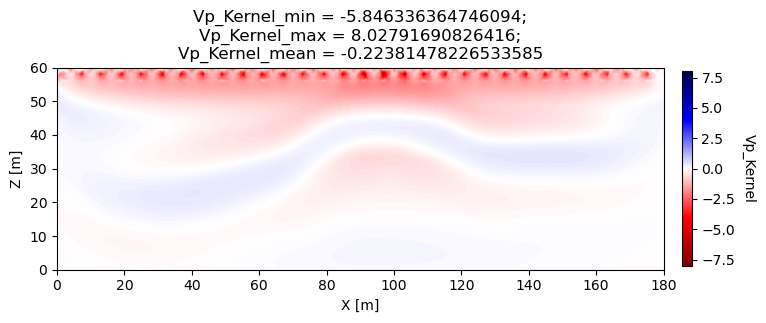

In [72]:
gradient_01 = Model(os.path.join("output", "GRADIENT_01"))
gradient_01.plot2d("vp_kernel")

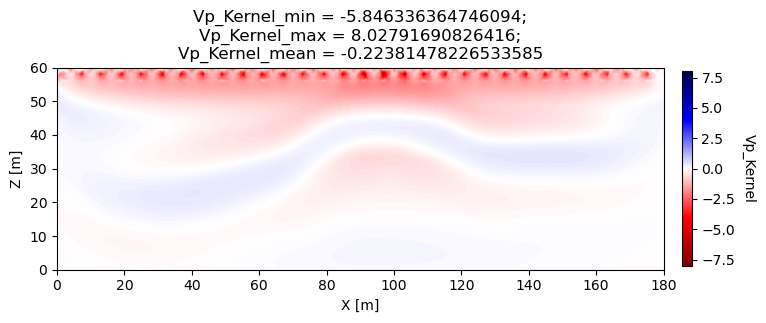

In [73]:
!cp /csim1/zhangchang/testmodel/output/MODEL_TRUE/proc000000_x.bin /csim1/zhangchang/testmodel/output/GRADIENT_01/proc000000_x.bin 
!cp /csim1/zhangchang/testmodel/output/MODEL_TRUE/proc000000_z.bin /csim1/zhangchang/testmodel/output/GRADIENT_01/proc000000_z.bin 
gradient_01 = Model(os.path.join("output", "GRADIENT_01"))
gradient_01.plot2d("vp_kernel")

In [74]:
model1 = Model(os.path.join("output", "MODEL_02"))
model1.plot2d("vs")

2024-06-30 21:45:20 [WARN] | no/invalid `path` given, initializing empty Model


TypeError: argument of type 'NoneType' is not iterable

In [43]:
import numpy as np
import pathlib

path_adj = pathlib.Path("scratch", "solver", "mainsolver", 'traces', 'adj')
adjs = sorted(path_adj.glob("*BXX.adj"))

adjs_data = []
for adj in adjs:
    adjs_data.append(np.loadtxt(adj)[:, 1])

adjs_data = np.array(adjs_data)
adjs_data.shape

(90, 5000)

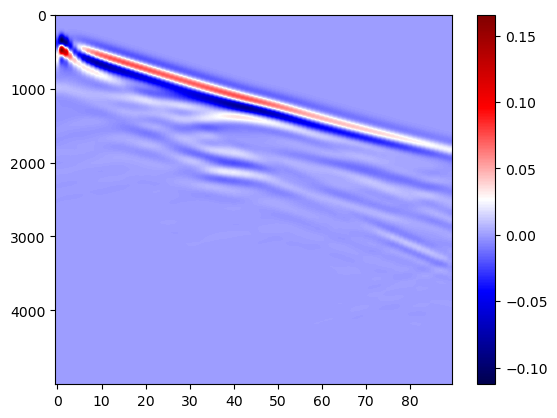

In [44]:
import matplotlib.pyplot as plt

plt.imshow(adjs_data.T, cmap='seismic', aspect='auto')
plt.colorbar()

In [77]:
import numpy as np
import pathlib

path_adj = pathlib.Path("scratch", "solver", "mainsolver", 'traces', 'syn')
syn = sorted(path_adj.glob("*BXX.semd"))

syn_data = []
for adj in syn:
    syn_data.append(np.loadtxt(adj))
syn_data = np.array(syn_data)[..., 1]

syn_data.shape

path_adj = pathlib.Path("scratch", "solver", "mainsolver", 'traces', 'obs')
obs = sorted(path_adj.glob("*BXX.semd"))

obs_data = []
for adj in obs:
    obs_data.append(np.loadtxt(adj))
obs_data = np.array(obs_data)[..., 1]

obs_data.shape

adj_diff = syn_data - obs_data

Text(0.5, 1.0, 'adj')

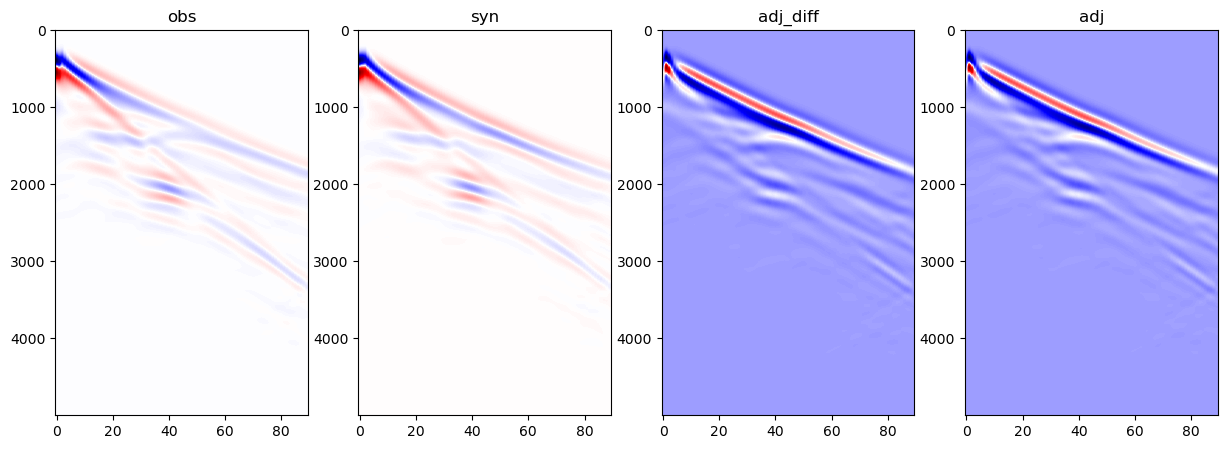

In [78]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(obs_data.T, cmap='seismic', aspect='auto')
axes[1].imshow(syn_data.T, cmap='seismic', aspect='auto')
axes[2].imshow(adj_diff.T, cmap='seismic', aspect='auto')
axes[3].imshow(adjs_data.T, cmap='seismic', aspect='auto')

axes[0].set_title("obs")
axes[1].set_title("syn")
axes[2].set_title("adj_diff")
axes[3].set_title("adj")

In [79]:
###########################

In [81]:
syn_data.shape

(90, 5000)

In [53]:
path_adj.glob("*BXX.semd")

<generator object Path.glob at 0x7d20ff7ecae0>

In [54]:
specfem2d_workdir/OUTPUT_FILES_INIT

[]

(90, 5000)


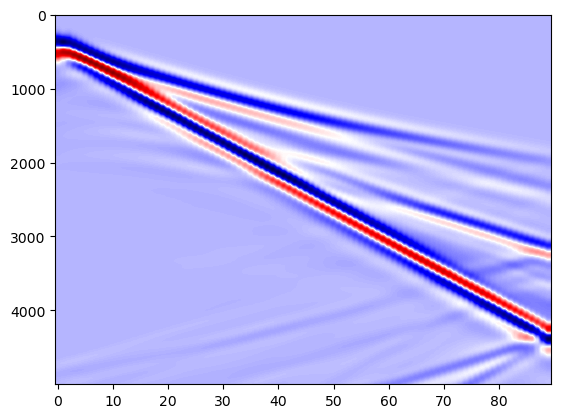

In [45]:
import numpy as np
import pathlib

path_data = pathlib.Path("specfem2d_workdir", "OUTPUT_FILES_INIT")
adjs = sorted(path_data.glob("*BXX.semd"))

seismo_v = []
for adj in adjs:
    seismo_v.append(np.loadtxt(adj)[:, 1])

seismo_v = np.array(seismo_v)
seismo_v_init_xx = seismo_v
print(seismo_v.shape)
plt.imshow(seismo_v.T, cmap='seismic', aspect='auto')

(90, 5000)


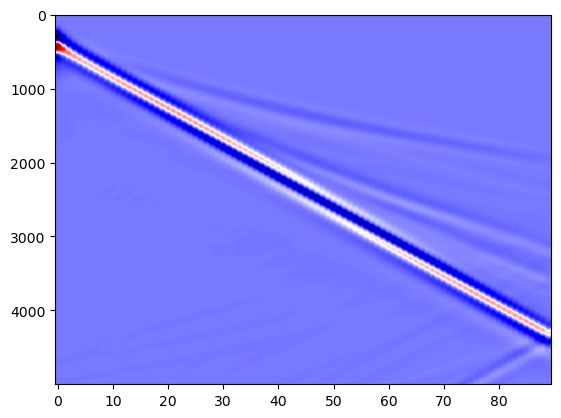

In [46]:
import numpy as np
import pathlib

path_data = pathlib.Path("specfem2d_workdir", "OUTPUT_FILES_INIT")
adjs = sorted(path_data.glob("*BXZ.semd"))

seismo_v = []
for adj in adjs:
    seismo_v.append(np.loadtxt(adj)[:, 1])

seismo_v = np.array(seismo_v)
seismo_v_init_xz = seismo_v
print(seismo_v.shape)
plt.imshow(seismo_v.T, cmap='seismic', aspect='auto')

(90, 5000)


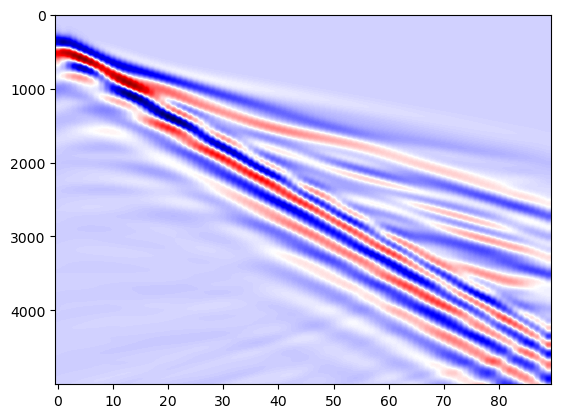

In [47]:
import numpy as np
import pathlib

path_data = pathlib.Path("specfem2d_workdir", "OUTPUT_FILES_TRUE")
adjs = sorted(path_data.glob("*BXX.semd"))

seismo_v = []
for adj in adjs:
    seismo_v.append(np.loadtxt(adj)[:, 1])

seismo_v = np.array(seismo_v)
print(seismo_v.shape)
seismo_v_true_xx = seismo_v
plt.imshow(seismo_v.T, cmap='seismic', aspect='auto')

(90, 5000)


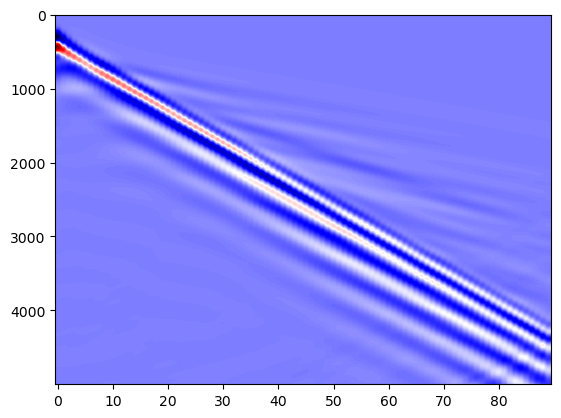

In [48]:
import numpy as np
import pathlib

path_data = pathlib.Path("specfem2d_workdir", "OUTPUT_FILES_TRUE")
adjs = sorted(path_data.glob("*BXZ.semd"))

seismo_v = []
for adj in adjs:
    seismo_v.append(np.loadtxt(adj)[:, 1])

seismo_v = np.array(seismo_v)
print(seismo_v.shape)
seismo_v_true_xz = seismo_v
plt.imshow(seismo_v.T, cmap='seismic', aspect='auto')

In [49]:
import scipy.io as sio
sio.savemat('specfem_trace_layermodel.mat',{'seismo_v_true_xz':seismo_v_true_xz.T,'seismo_v_true_xx':seismo_v_true_xx.T,'seismo_v_init_xz':seismo_v_init_xz.T,'seismo_v_init_xx':seismo_v_init_xx.T})